# Open data, private data, big data, small data

_The technological innovation of differential privacy allows sharing of personal data with privacy guarantees—but implementing differential privacy should makes us think about what we want to get from an open dataset._ 

By Tim McGovern


Apple made headlines (and caused some headscratching) with their announcement this summer that that they’d be widely implementing a technique called “differential privacy” to ensure the privacy of personal data they were gathering—while still keeping it useful to their data scientists and developers. In this post, I’ll give an introduction to differential privacy and tease out some of its implications, particularly for open data advocates. 

### “Have you ever sold drugs?”

Imagine you’re a university researcher, trying to figure out the prevalence of drug dealing on your campus. You want to ensure the privacy of your respondents’ answers—they will speak more freely if guaranteed absolute privacy. And you and they both will be protected from prosecution, of course! 

Here’s a procedure you could implement: each respondent is given a survey, as well as a coin to flip. When they get to the question about illegal drug dealing, they’re instructed to flip the coin: if it comes up heads, they answer correctly, if it comes up tails, then they flip the coin again and answer “yes” if it comes up heads and “no” if it comes up tails, without any regard for what the truth of their behavor is. 


[insert flow chart] 

[insert model]


In [1]:
import random
import matplotlib.pyplot as plt 
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np 
%matplotlib inline
import csv

In [103]:
'''Let's define ground truth as 25% of respondents dealing drugs, 
and we'll keep it super-simple: respondents 0-124 have, and 125-499 have not.''' 
groundtruth = {}
for n in range(0,125):
    groundtruth[n] = 1
for n in range(125,500):
    groundtruth[n] = 0

In [104]:
#Our survey procedure model will return either an accurate or a random answer.

def survey(n,truth):
    firstflip = random.randint(0,1)
    if firstflip:
        return(truth)
    else:
        return(random.randint(0,1))


In [105]:
#Let's run the survey on our sample population:

dealers = 0
for student in groundtruth:
    dealers += survey(student,groundtruth[student])
dealers

200

## What does it mean? 

We now have six categories of answers: 

<table>
    <tr>
        <td> </td>
        <td>*Deal* </td>
        <td> *Don't deal* </td>
    </tr>
    <tr>
        <td>Told the truth</td>
        <td>Truthfully said  they deal: **YES** (~50% of the 125 dealers)</td>
        <td>Truthfully said they don't deal: **NO**  (~50% of the 375 non-dealers)</td>
    </tr>
    <tr>
        <td>Flipped coin for answer, got heads, *adds up to 25% of total sample*</td>
        <td>**YES** (~25% of 125 dealers)</td>
        <td>**YES** (~25% of 375 non-dealers)</td>
    </tr>
    <tr>
        <td>Flipped coin for answer, got tails, *adds up to 25% of total sample* </td>
        <td>**NO** (~25% of 125 dealers)</td>
        <td>**NO** (~25% of 375 non-dealers)</td>
    </tr>
<table>    
But let's put ourselves in the shoes of the university researcher—we don't know the number of dealers! 

Math to the rescue. Let's simplify just a little bit and only worry about our 'yes' survey results. 

>Dealers who gave a truth-based answer of *YES* (`realdealers * 0.5`) 

>Dealers and non-dealers who gave a coin-flip-based answer of *YES* (500 * 0.25`)

Simplifying: 

`realdealers * 0.5 + (500 * 0.25) = dealers
realdealers * 0.5 + 125 = dealers
realdealers * 0.5 = dealers - 125
realdealers = (dealers - 125) * 2`

In [106]:
realdealers = (dealers - 125) * 2
realdealers

150

## But wait, there's more!

Working with differentially-private data can in fact encourage _better_ data science. With the addition of random 'noise,' you are forced to reckon with the randomness and non-representation of the real world—your awareness of the fact that your data is not 100% certain is 'built in'. 

## We can look at the differentially-private data in probabilistic terms

What happens if we run our sample 10,000 times? 

In [108]:
#Starting from the same groundtruth data, we'll run the exact same survey 10,000 times. 
#Thank God these are virtual, not real, college students. 


aggregateresults = []
for n in range(0,10000):
    dealers = 0
    for student in groundtruth:
        dealers += survey(student,groundtruth[student])
    realdealers = (dealers - 125) * 2 #NOTE: we're multiplying an integer by 2, our RESOLUTION is 2
    aggregateresults.append(int(realdealers))
   

In [125]:
# This just makes graphing it a little easier, by taking the empty slots out of the bins
graphaggres = [res/2 for res in aggregateresults] 

/Users/tmcgovern/Anaconda/anaconda/envs/py3k/lib/python3.4/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/tmcgovern/Anaconda/anaconda/envs/py3k/lib/python3.4/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


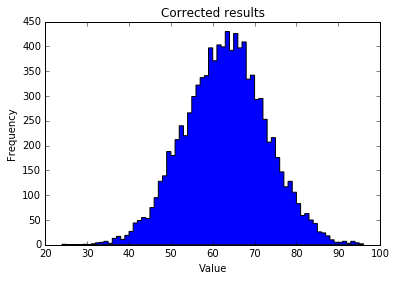

In [110]:
bincount = max(graphaggres) - min(graphaggres)
plt.hist(graphaggres, bins=bincount, histtype='stepfilled')
plt.title("Corrected results")
plt.xlabel("Value")
plt.ylabel("Frequency");


In [111]:
np.mean(aggregateresults)

125.09139999999999

In [112]:
np.median(aggregateresults)

126.0

Hopefully, I've convinced you that this method of data gathering produces a number that's somehow distributed around the real number. 

# How does the noise-added version compare to just sampling 50%?

By flipping a coin we took a sample of about 50% of our data, and then added noise. How does the version with the noise added (then subtracted) compare to just taking a 50% sample? 

In [118]:
#So we'll tweak our survey a bit, so that the first draw determines whether you tell the truth or just don't respond
aggsurv2 = []
for n in range(0,10000):
    surveydata2 = 0
    sample = random.sample(list(groundtruth), 250)
    for n in sample:
        surveydata2 += groundtruth[n]
    aggsurv2.append(int(surveydata2))


/Users/tmcgovern/Anaconda/anaconda/envs/py3k/lib/python3.4/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/tmcgovern/Anaconda/anaconda/envs/py3k/lib/python3.4/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


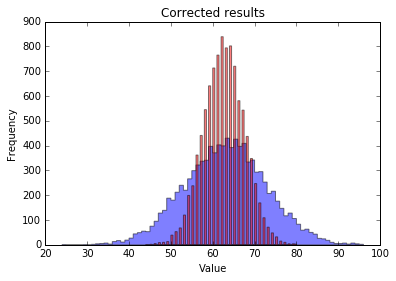

In [124]:
bincount = max(graphaggres) - min(graphaggres)
bincount2 = (max(aggsurv2) - min(aggsurv2))/2
plt.hist(graphaggres, bins=bincount, histtype='stepfilled',color = "blue", alpha=0.5)
plt.hist(aggsurv2, bins=bincount, histtype='stepfilled',color = "red", alpha=0.5)
plt.title("Corrected results")
plt.xlabel("Value")
plt.ylabel("Frequency");


## We want to put a _confidence interval_ around this number. 

What is a confidence interval? 

Because our researchers don't have access to ground-truth data, we want to figure out: 
Given a particular result `realdealers` from just one run of the experiment, how likely is it that `groundtruth` is something else? We express confidence intervals in terms of percentages and ranges: Given result X, we are P% sure that the result is between W and Y." This means that given our data-gathering method, if `groundtruth` is between W and Y, we get `realdealers` as a result P% of the times we run this experiment. 

We know that `realdealers` is a probabilistic function normally distributed around `groundtruth` for any particular value of `realdealers` and `groundtruth`, and there are statistical equations that have done this math for us, but because I'm using computers to do this (and, umm, I never learned statistics) I'm going to make the computer do this all by means of simulations. I.e., The loooooooong way. 

Onward. 

### The problem

For a given number `realdealers` and percentage confident `conf` we want to know the range around it for which other groundtruths produce a `realdealers` result `conf` percent of the time or greater. So we can pre-calculate 10,000 `realdealers` results for _every_ possible `groundtruth`. (Because this is pre-calculable, that's why we could lean on wiser statisticians than have come before.)

In [ ]:

def simulation(dealersseq):
    groundtruth = {}
    for n in range(0,dealersseq):
        groundtruth[n] = 1
    for n in range(dealersseq,500):
        groundtruth[n] = 0
        
    aggregateresults = []
    for n in range(0,10000):
        surveydata = []
        for student in groundtruth:
            surveydata.append(survey(student,groundtruth[student]))
        dealers = 0
        for n in surveydata:
            if n[1] == 1:
                dealers += 1
        realdealers = (dealers - 125) * 2
        aggregateresults.append(realdealers)
    return(aggregateresults)

In [ ]:
#THIS IS FIVE MILLION RANDOM DRAWINGS. IT TAKES A FEW HOURS. DON'T RE-RUN UNLESS NEEDED -- Commenting out
'''output_file = '500times.csv'
with open(output_file, 'w', newline='') as filewriter:
    for n in range(0,500):
        simdata = simulation(n)
        for num in range(-500,500):
            filewriter.write(str(simdata.count(num)) + ',')
        filewriter.write('\n')
        '''

In [ ]:
#THIS IS FIVE MILLION RANDOM DRAWINGS. IT TAKES A FEW HOURS. DON'T RE-RUN UNLESS NEEDED -- Commenting out
'''output_file = '101_200times.csv'
with open(output_file, 'w', newline='') as filewriter:
    for n in range(101,200):
        filewriter.write(str(simulation(n)))
        filewriter.write('\n')'''

In [13]:
bigagg = []

input_files = ["50times.csv", "51_100times.csv","101_200times.csv"]
for input_file in input_files:
    with open(input_file, 'r', newline='') as csv_in_file:
        filereader = csv.reader(csv_in_file, delimiter = ',')
        for row in filereader:
            bigagg.append(row)        

In [14]:
for row in bigagg:
    row[0] = row[0].lstrip('[')
    row[-1] = row[-1].rstrip(']')

bigagg = [[int(m) for m in row] for row in bigagg]


In [17]:
overallmin = min([min(agg) for agg in bigagg])
overallmax = max([max(agg) for agg in bigagg])


In [20]:
reresults = {}
for n in range(overallmin, overallmax):
    reresults[n] = []
    for m in range(0, len(bigagg)):
        for p in bigagg[m]:
            if p == n:
                reresults[n].append(m)
        

In [27]:
np.mean(reresults[100])

100.0653205451792

In [41]:
xs = []
for n in range(overallmin,overallmax):
    if len(reresults[n]):
        xs.append(n)
        

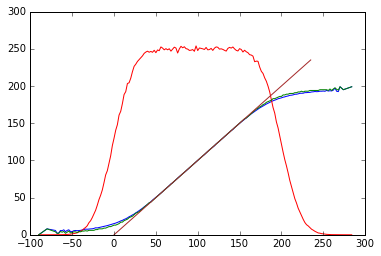

In [123]:
y1 = [np.mean(reresults[n]) for n in xs]
y2 = [len(reresults[n]) / 80 for n in xs]
y3 = [np.median(reresults[n]) for n in xs]

plt.plot(xs, y1, color='blue')
plt.plot(xs, y2, color='red')
plt.plot(xs, y3, color='green')
plt.plot(range(0,(overallmax-50)), range(0,(overallmax-50)), color='brown');


## What's going on here? 

Obviously, there's less data to be used at the ends of our range, and so when we get really far out into the wings of the distribution, we're dealing with just one or two times that these results appeared. 

For a confidence interval, we want to know the range within which 95% of the times we got a given result, it was produced by a groundtruth with the range(conmin, conmax). 

In [ ]:
x = [n for n in range(0,501)]
y1 = [np.mean(bigagg[n]) for n in x]
#y2 = [np.mode(bigagg[n]) for n in x]
y3 = [np.median(bigagg[n]) for n in x]

plt.plot(x, y1, color='blue')
#plt.plot(x, y2, color='red')
plt.plot(x, y3, color='green');

In [ ]:
x = [n for n in range(0,501)]
y1 = [(np.mean(bigagg[n]) - n) for n in x]

#y3 = [(np.median(bigagg[n]) - n) for n in x]

plt.plot(x, y1, color='blue')
#plt.plot(x, y2, color='red')
#plt.plot(x, y3, color='green')

In [ ]:
def conint(res,pct):
    center = round(np.mean(bigagg[res]))
    #total number of groundtruths we want to reach is pct% of the total number of draws we did, i.e. 10,000
    tottruths = pct * 10000
    #start at the center of our distribution, counting the number of truths that were at that mean
    runningtruths = bigagg[res].count(center)
    #work up and down simultaneously, counting the number of truths at each of these times
        #but if the up-counter hits 500, or the down-counter hits 0, stop. 
    c = 1
    lowerbound = center
    upperbound = center
    if 
    while runningtruths < tottruths: #stop when the count gets to tottruths
        upperbound = center + c
        lowerbound = center - c
        if upperbound <= 500:
            runningtruths = runningtruths + bigagg[res].count(upperbound)
            
        if lowerbound >= 0:
            runningtruths = runningtruths + bigagg[res].count(lowerbound)
            
        c += 1
    
    return(max(lowerbound, 0), center, min(upperbound,500))
    

In [ ]:
max(bigagg[500])

In [ ]:
x = [n for n in range(0,501)]
y1 = [conint(n)[0] for n in x]
y2 = [conint(n)[1] for n in x]
y3 = [conint(n)[2] for n in x]
plt.plot(x, y1, color='blue')
plt.plot(x, y2, color='red')
plt.plot(x, y3, color='green')

## Where are we now?
# Gah, this all needs to be rewritten.
OK, so now we've pre-processed and made a big (500 rows, 1000 columns) table where each row represents a different ground truth (equal to its index), each column represents a potential result from -500 to 500, and the data in the cell is how many times that ground truth produced that calculated survey result. 

Let's see what it looks like!

In [ ]:
input_file = "500times.csv"
bigagg = []
with open(input_file, 'r', newline='') as csv_in_file:
    filereader = csv.reader(csv_in_file, delimiter = ',')
    for row in filereader:
        bigagg.append(row[:-1])

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')
x = [n for n in range(0,1000,2)] #Every other row so we don't graph all the zeroes.
y = [n for n in range(0,500)]
z = []
for row in bigagg:
    shortened = []
    for n in range(0,1000,2):
        shortened.append(row[n])
    z.append(shortened)
z = [[float(m) for m in n] for n in z]
xs = [[m for m in range(len(x))] for n in range(len(y))]
ys = [[n for m in range(len(y))] for n in range(len(x))]
zs = [[elem for elem in row] for row in z]

surf = ax.plot_surface(xs, ys, zs, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

So we've got a nice ridge that runs diagonally right where we'd expect. (It goes from 250-500 because it's all the even numbers from -500 to 500 mapped onto the integers from 1-500.)

Let's take a little closer look at this, and see how the means, modes, and medians of the simulated runs compare with the groundtruths for each simulation. 

First, we'll turn the table on its side, though, so that our rows are the results and the columns are all the groundtruths that produced those results. That way we can more easily work out which (and how many of which) groundtruths produced any given result. 



In [ ]:
betteragg = []
for n in range(len(bigagg[0])):
    betteragg.append([])
    for m in range(len(bigagg)):
        betteragg[n].append(int(bigagg[m][n]))

In [ ]:
def meanfunc(res):
    x = 0
    n = res + 500 
    for m in range(0,500):
        x = x + (m * betteragg[n][m])
    return(x/sum(betteragg[n]))


In [ ]:
def medianfunc(res):  
    
    rawdistro = []
    for n in range(0,len(betteragg[res + 500])):  #for each element in the histogram list
        for m in range(0,betteragg[res + 500][n]):     #we want, that element times
            rawdistro.append(n)   #to put the index in
    return np.median(rawdistro)
    

In [ ]:
def modefunc(res):
    resset = betteragg[(res + 500)]
    totaltruths = sum(resset) #This is total number of groundtruths that produced the result we have.
    return(resset.index(max(resset)))

In [ ]:
x = np.arange(0,500,2)
y1 = [meanfunc(n) for n in x]
y2 = [modefunc(n) for n in x]
y3 = [medianfunc(n) for n in x]

plt.plot(x, y1, color='blue')
plt.plot(x, y2, color='red')
plt.plot(x, y3, color='green');


In [ ]:
x = np.arange(450,500,2)
y1 = [meanfunc(n) for n in x]
y2 = [modefunc(n) for n in x]
y3 = [medianfunc(n) for n in x]

plt.plot(x, y1, color='blue')
plt.plot(x, y2, color='red')
plt.plot(x, y3, color='green')
plt.plot(x, x, color='orange');



In [ ]:
x = np.arange(0,50,2)
y1 = [meanfunc(n) for n in x]
y2 = [modefunc(n) for n in x]
y3 = [medianfunc(n) for n in x]

plt.plot(x, y1, color='blue')
plt.plot(x, y2, color='red')
plt.plot(x, y3, color='green')
plt.plot(x, x, color='orange');

In [ ]:
x = np.arange(0,500,2)
v = [meanfunc(n) - n for n in x]
plt.plot(x, v);

In [ ]:
x = np.arange(0,500,2)
v = [medianfunc(n) - n for n in x]
plt.plot(x, v);

In [ ]:
x = np.arange(0,500,2)
v = [modefunc(n) - n for n in x]
plt.plot(x, v);

In [ ]:
#Let's take a 3-dimensional look at what's going on there at the ends of the distribution. 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')
x = [n for n in range(900,1000,2)] #Every other row so we don't graph all the zeroes.
y = [n for n in range(450,500)]
z = []
for row in bigagg[450:]:
    shortened = []
    for n in range(900,1000,2):
        shortened.append(row[n])
    z.append(shortened)
z = [[float(m) for m in n] for n in z]
xs = [[m for m in range(len(x))] for n in range(len(y))]
ys = [[n for m in range(len(y))] for n in range(len(x))]
zs = [[elem for elem in row] for row in z]

surf = ax.plot_surface(xs, ys, zs, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')
x = [n for n in range(500,600,2)] #Every other row so we don't graph all the zeroes.
y = [n for n in range(0,50)]
z = []
for row in bigagg[0:50]:
    shortened = []
    for n in range(500,600,2):
        shortened.append(row[n])
    z.append(shortened)
z = [[float(m) for m in n] for n in z]
xs = [[m for m in range(len(x))] for n in range(len(y))]
ys = [[n for m in range(len(y))] for n in range(len(x))]
zs = [[elem for elem in row] for row in z]

surf = ax.plot_surface(xs, ys, zs, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Note that the accuracy of this method drops off at the extremes. This is a known—even intentional—artefact of differentially-private data analysis; when there are only a few cases, the noise gets relatively bigger so you can't find out about a few individual cases. 

### To Do: build out confidence-interval function. 


In [ ]:
#We'll borrow the unaggregated-data-returning function we built to discover medians:


    

In [ ]:
#Confidence interval
def conint(res,conlevel):
    runtot = []
    for 

# What if my goal is to find the drug dealers? 

Differential privacy is explicitly _not good_ at this. Differential privacy is explicitly built to make it almost-no-better-than random guessing. That is the point. But, even aside from the fact that differential privacy pushes users to think hard about the statistical significance of their results, it reminds us to think hard about the goals of data gathering, analysis, and release. 

## Is it data science? Or medicine? Or are you running a data dragnet?

Another "Counting" example was Google gathering usage data about whether users were proceeding to potentially dangerous sites after receiving a "don't go to this website" warning. [Cite: Moritz Hardt post]

Difference between gathering data to find out a link between smoking and cancer and finding out that a specific person is a smoker. 

(Data) Science is about finding generalizable trends. 

Open data may be used for data science, but it can also be used for finding anecdotes, finding specific anomalies and specific people. [New York taxi data!]

Divvy dataset: I was a little horrified, honestly, and I started poking around at it to see literally how many clicks in Excel it would take me to find an individual commuter. But there's a lot of bad user-provided data! Lots of 1912 birthdays, for example. 

## Build trust, get better data. 



In [ ]:
round(3.5)

In [88]:
random.sample?

## Why is this useful? 

The intuitive reason this is useful is because even if we know who a respondent with a given number is, the survey result we have from that person is, as likely as not, a random answer. More formally—and this is what makes differential privacy "differential," the aggregate survey results are not changed by the inclusion or exclusion of anyone's data. 

This is vitally important because the way you deanonymize data is to take slices of it based on outside information—you may know a respondent's age, gender, or other research categories that I am interested in. In this particular case, it might be family income, hometown, etc. And you can take narrower and narrower slices of the data until you're left with just my data. 

With differential privacy implemented, you can gather data and make inferences about the data; we don't have to limit ourselves to counting, but we could find out risk factors for drug dealing among our population—gender, family income...whatever your research object of interest is—and despite the fact that you are gathering a great deal of data, any single person's data is protected by a halo of "noise." 